In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import itertools
import random
import operator
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

from sat_metropolis import smt, mcmc, sat, utils, models

In [2]:
#32 Haplotypes
#5 placings in the haplotype (2⁵ = 32)
#100 genotypes

haplotypes = list(map(list, itertools.product([0, 1], repeat=5)))
haplotypesProb = [
    0.0056,   0.004,                0.00368,  0.1,                 
    0.005681, 0.09,                 0.00468,  0.003,    
    0.08,     0.006147,             0.00595,  0.0071,   
    0.00345,  0.00632,              0.1,      0.0029,   
    0.0071,   0.006147,             0.085,    0.0045671,
    0.003379, 0.1,                  0.00461,  0.00614,             
    0.075,    0.08,                 0.00761,  0.004321, 
    0.09,     0.009217900000000112, 0.0134,   0.075]

In [3]:
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

In [4]:
genotypes = []
d = {'h_1': [], 'h_2': [], 'g': []}
for i in range(100):
    h1 = np.random.choice(np.arange(32), p=haplotypesProb) 
    h2 = np.random.choice(np.arange(32), p=haplotypesProb) 
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2])))
    d['h_1'].append(haplotypes[h1]); d['h_2'].append(haplotypes[h2]); d['g'].append(genotypes[i]); 
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] +1 
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] +1 
df = pd.DataFrame(data=d)

In [5]:
df

,h_1,h_2,g
0,"[1, 1, 1, 0, 0]","[1, 1, 1, 1, 1]","[2, 2, 2, 1, 1]"
1,"[1, 0, 1, 0, 1]","[1, 1, 1, 1, 1]","[2, 1, 2, 1, 2]"
2,"[0, 1, 1, 0, 1]","[1, 1, 0, 0, 1]","[1, 2, 1, 0, 2]"
3,"[0, 1, 1, 1, 0]","[1, 0, 0, 1, 0]","[1, 1, 1, 2, 0]"
4,"[1, 1, 1, 0, 0]","[0, 1, 1, 1, 0]","[1, 2, 2, 1, 0]"
...,...,...,...
95,"[1, 1, 1, 0, 0]","[0, 0, 1, 0, 1]","[1, 1, 2, 0, 1]"
96,"[0, 1, 1, 1, 0]","[1, 1, 0, 0, 0]","[1, 2, 1, 1, 0]"
97,"[1, 1, 0, 0, 1]","[1, 0, 0, 1, 0]","[2, 1, 0, 1, 1]"
98,"[0, 1, 1, 1, 0]","[1, 1, 0, 0, 1]","[1, 2, 1, 1, 1]"


In [6]:
(g, num_bits, num_vars) = models.get_haplotypes_sat(genotypes=np.array(genotypes))

In [7]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000)

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4615/4615/0
independent support size:  	0
clauses (all/long/binary/unit): 10325/4460/4500/1365
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	629 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	629 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	4615/4615/0
clauses (removed) 		10325 (0)
decisions 				250
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1365
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache siz

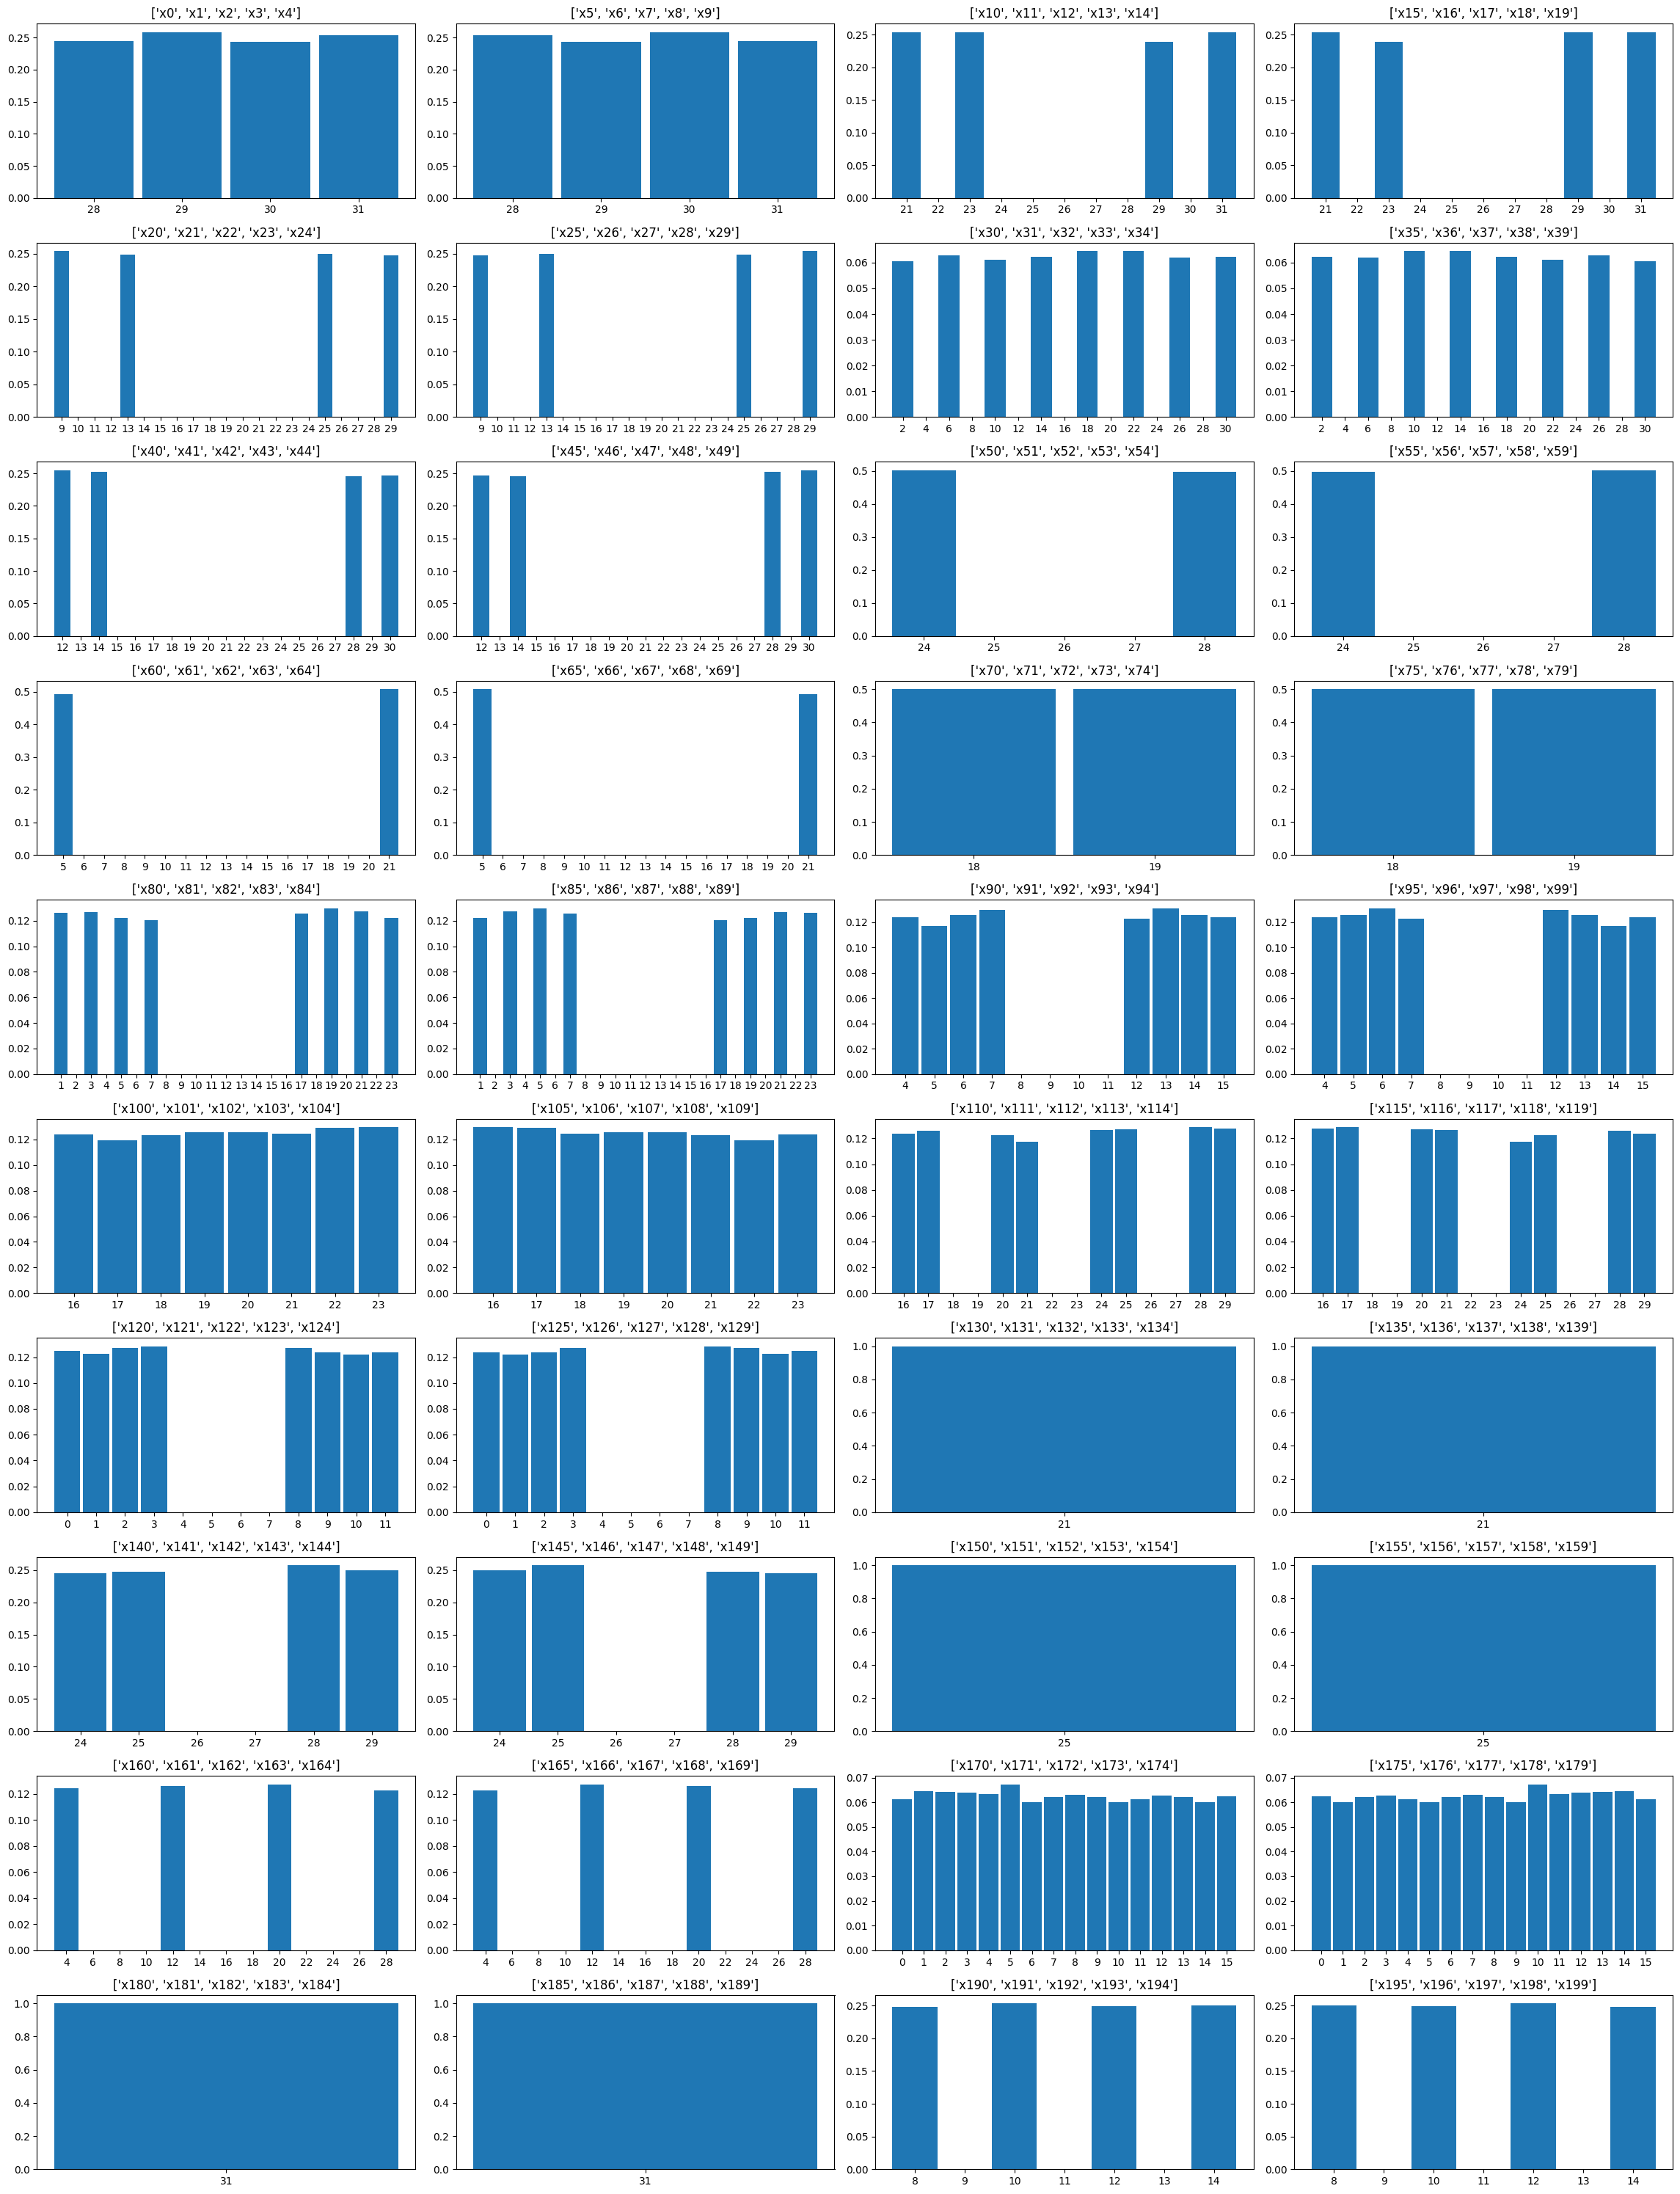

In [8]:
plot_posterior_haplotype = lambda var_names, ax: az.plot_dist(np.array(list(map(lambda x: int("".join(str(y) for y in x),2),trace.posterior[var_names].to_array().values.reshape(5,-1).T))),ax=ax)

num_vars = 200
num_haplotype_vars = int(num_vars/5)
num_rows = int(num_haplotype_vars/4)
size_y   = 3*num_rows

fig, axs_m = plt.subplots(nrows=num_rows, ncols=4, figsize=(23,size_y))
axs = axs_m.ravel()
for i in np.arange(0,num_vars,step=5):
    var_names = [f'x{i+j}' for j in range(5)]
    ax = axs[int(i/5)]
    plot_posterior_haplotype(var_names, ax=ax)
    ax.set_title(var_names)
# plt.tight_layout();
plt.savefig('posterior_haplotypes.png',dpi=150);
plt.show();

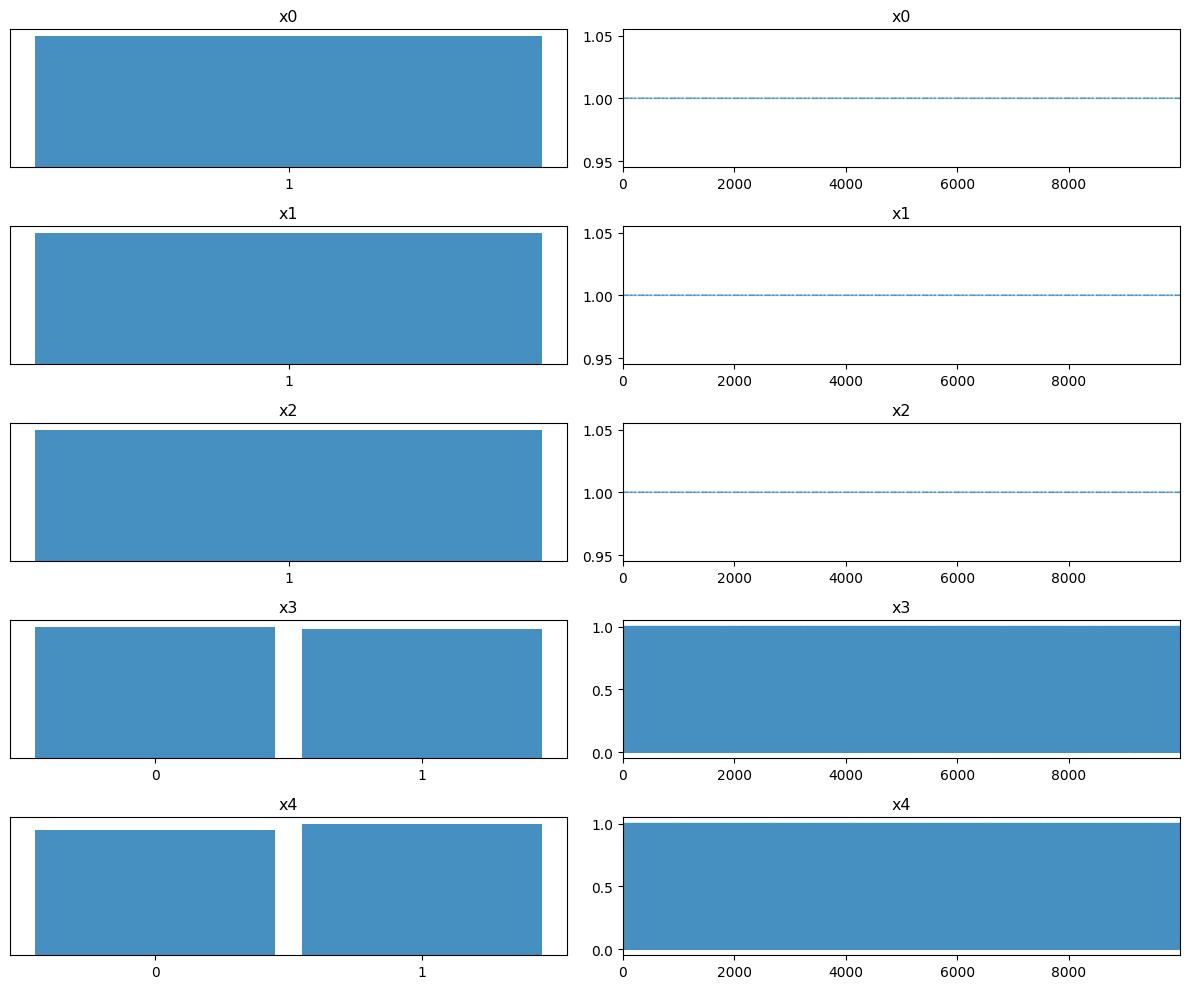

In [9]:
# Plot the posterior
az.plot_trace(trace, var_names=['x0', 'x1', 'x2', 'x3', 'x4']);
plt.savefig('spur_trace_plot_haplotypes.png', dpi=150);

In [10]:
# Diagnostics
az.summary(trace,  var_names=['x0', 'x1', 'x2', 'x3', 'x4'])

/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.000,0.0,1.0,1.0,0.000,NaN,40000.0,40000.0,NaN
x1,1.000,0.0,1.0,1.0,0.000,NaN,40000.0,40000.0,NaN
x2,1.000,0.0,1.0,1.0,0.000,NaN,40000.0,40000.0,NaN
x3,0.497,0.5,0.0,1.0,0.002,0.0,40470.0,40000.0,1.0
x4,0.512,0.5,0.0,1.0,0.003,0.0,39251.0,39251.0,1.0


In [11]:
az.to_netcdf(trace, f'haplotypes_spur_genotypes_{len(genotypes)}.nc')

'haplotypes_spur_genotypes_100.nc'